## PCA, SVD, t-SNE and Neural Network on Stock Return Classification

In [1]:
"""
Maths156 Final Project Group 6 Code Part
"""
import warnings
import os
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("156Data3(1)(1).xlsx")
df = df.drop(0)
name = list(df.columns) 
df

stock = []
new_df_list = []
for i, j in enumerate(name):
    if 'Unnamed' not in j:
        stock.append(i)
        
prev_index = 0
for i in stock[1:]:
    sub_df = df[df.columns[prev_index:i-1]]
    prev_index = i
    new_df_list.append(sub_df)
    
col = ["pe_lyr","pb_lyr","MACD","RSI","val_lnmv","tech_revs10","fa_eps_basic",
                  "fa_operincometopbt","fa_npgr_ttm","pcf_ncf_ttm","fa_roa_ttm","fa_tagr",
                  "MTM","ROC","eps_ttm","val_peindu_sw","tech_ad6","tech_mass","tech_psy",
                  "tech_cry","tech_EMA10","tech_chg_avg","pct_chg"]

In [3]:
def ext_data(m,month):
    for i in new_df_list:
        stock_df = i
        stock_df.columns = stock_df.loc[2]
        stock_df = stock_df.drop([1, 2])
        temp = stock_df[col]
        if not temp.isnull().values.any():
            m = np.concatenate((m, list(temp.loc[month+2])))
    return m

In [4]:
def result(m,avg):
    for i in range(404):
        if m[i] < avg:
            m[i] = -1
        else: m[i] = 1  
    return m

Standardization

In [5]:
def Standardization(m):
    scaler = StandardScaler()
    scaler.fit(m)
    my_new_matrix = scaler.transform(m)
    my_new_matrix.shape
    return my_new_matrix

PCA dimension reduction function

In [6]:
def new_PCA(X_std_train, X_std_test, y_train, y_test):

    pca = PCA(n_components = 8)
    X_new_train = pca.fit_transform(X_std_train)
    X_new_test = pca.fit_transform(X_std_test)
    
    y_train = y_train.tolist()
    X_new_train = X_new_train.tolist()
    X_new_test = X_new_test.tolist()
    y_test = y_test.tolist()
    
    return X_new_train, X_new_test, y_train, y_test

SVD dimension reduction function

In [54]:
def new_SVD(X_std_train,X_std_test,y_train, y_test):   
    from scipy import linalg
    U1, s1, Vh1 = linalg.svd(X_std_train)
    U2, s2, Vh2 = linalg.svd(X_std_test)
    import numpy as np
    sigma1 = np.zeros((404, 22))
    for i in range(min(404, 22)):
        sigma1[i, i] = s1[i]
    X_new_train = np.dot(U1, np.dot(sigma1, Vh1))

    sigma2 = np.zeros((404, 22))
    for i in range(min(404, 22)):
        sigma2[i, i] = s2[i]
    X_new_test = np.dot(U2, np.dot(sigma2, Vh2))
    X_new_train = X_new_train.tolist()
    X_new_test = X_new_test.tolist()
    y_train = y_train.tolist()
    y_test = y_test.tolist()
    return X_new_train, X_new_test,y_train, y_test

t-SNE dimension reduction function

In [50]:
def new_TSNE(X_std_train, X_std_test, y_train, y_test):    
    tsne = TSNE(n_components = 2, random_state=0)
    X_new_train = TSNE(n_components=2).fit_transform(X_std_train)
    X_new_train = X_new_train.tolist()
    X_new_test = TSNE(n_components=2).fit_transform(X_std_test)
    X_new_test = X_new_test.tolist()
    y_train = y_train.tolist()
    y_test = y_test.tolist()
    return X_new_train, X_new_test, y_train, y_test

Neural Network function (provides performance score)

In [40]:
def predict(X_new_train, X_new_test, y_train, y_test):
   
    # make a plot and demonstrate the results of cross-validation to seek the b
    fig, ax = plt.subplots(1)
    # we set the best score to zero first and then update it if a bigger value
    best_score = 0
    best_hidden_size = 1
    # we use a for loop to loop over the values of the hidden size
    for d in range(1,15):
        nn = MLPClassifier(solver='lbfgs',alpha=1e-9,hidden_layer_sizes=(d,d,d),random_state=0)
        cv_score = cross_val_score(nn, X_new_train, y_train, cv=10).mean()
    # we use scatter to draw the score values on the plot
        ax.scatter(d, cv_score, color = "black")
        if cv_score > best_score:
            best_hidden_size = d
            best_score = cv_score
    # we assign names to both axis and also make a title
    l = ax.set(title = "Best hidden size : " + str(best_hidden_size) + " Best Score: " + str(best_score),xlabel = "Hidden Sizes",ylabel = "CV Score")
    
    lin = MLPClassifier(solver="lbfgs",alpha=1e-3,hidden_layer_sizes=(best_hidden_size,best_hidden_size,best_hidden_size),random_state=0)
    # fit the model on our data and find the performance score of the model
    lin.fit(X_new_train, y_train)
    return lin.score(X_new_test, y_test)
    

PCA and NN application

In [41]:
def month_test_PCA(month):
    temp1 = np.array([])
    temp2 = np.array([])
    temp_matrix = np.array([])

    temp1 = ext_data(temp1, month) 
    temp1 = temp1.reshape(404, 23)
    X_train = temp1[:,0:22]
    temp2 = ext_data(temp2, month+1) 
    temp2 = temp2.reshape(404, 23)
    X_test = temp2[:,0:22]
    temp_matrix = ext_data(temp_matrix, month+2)
    temp_matrix = temp_matrix.reshape(404, 23)

    ## target

    y_train = temp2[:,22]   
    y_test = temp_matrix[:,22] 
    
    avg = [14.60943332,5.531467255,1.055434182,-7.242647341,5.394251458,0.255385444,
           -0.932637353,0.393200319,1.893286984,-1.494307583,6.997469095]

    y_train = result(y_train, avg[month-1])   
    y_test = result(y_test, avg[month])
    
    X_std_test = Standardization(X_test)
    X_std_train = Standardization(X_train)
    
    X_new_train, X_new_test, y_train, y_test = new_PCA(X_std_train, X_std_test, y_train, y_test)
    return predict(X_new_train, X_new_test, y_train, y_test)

[0.5173267326732673, 0.5792079207920792, 0.47277227722772275, 0.5346534653465347, 0.5222772277227723, 0.5668316831683168, 0.5123762376237624, 0.5173267326732673, 0.46782178217821785, 0.5222772277227723]


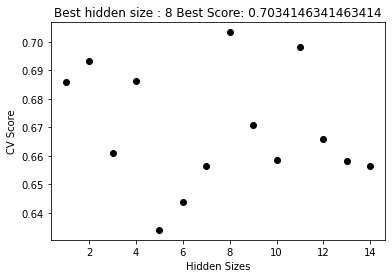

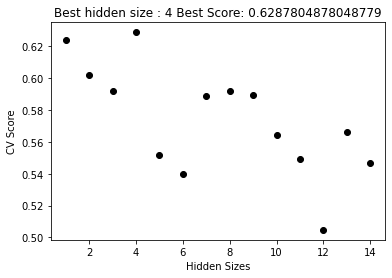

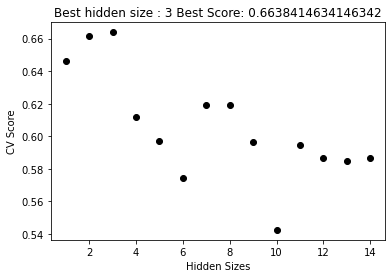

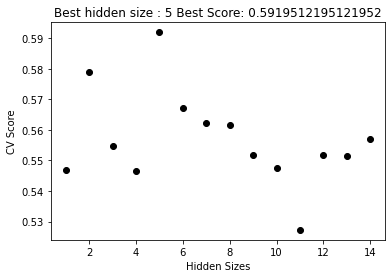

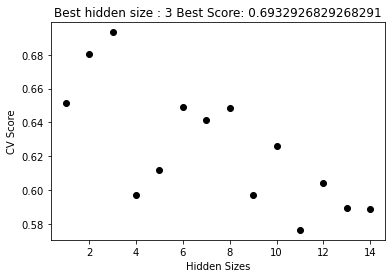

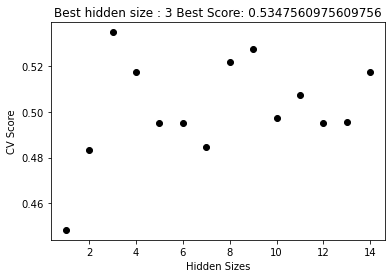

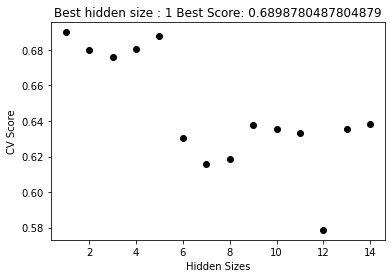

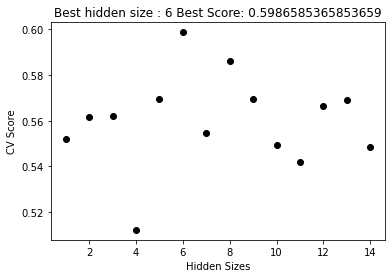

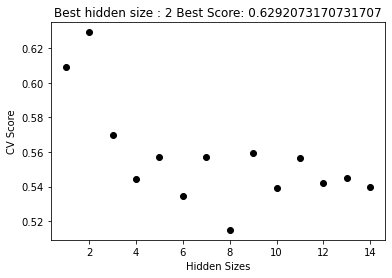

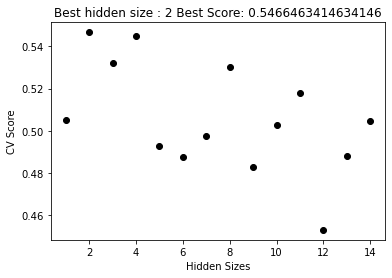

In [57]:
array_PCA = []
for i in range(1,11):
    array_PCA.append(month_test_PCA(i))
print(array_PCA)

In [51]:
def month_test_TSNE(month):
    temp1 = np.array([])
    temp2 = np.array([])
    temp_matrix = np.array([])

    temp1 = ext_data(temp1, month) 
    temp1 = temp1.reshape(404, 23)
    X_train = temp1[:,0:22]
    temp2 = ext_data(temp2, month+1) 
    temp2 = temp2.reshape(404, 23)
    X_test = temp2[:,0:22]
    temp_matrix = ext_data(temp_matrix, month+2)
    temp_matrix = temp_matrix.reshape(404, 23)

    ## target

    y_train = temp2[:,22]   
    y_test = temp_matrix[:,22] 
    
    avg = [14.60943332,5.531467255,1.055434182,-7.242647341,5.394251458,0.255385444,
           -0.932637353,0.393200319,1.893286984,-1.494307583,6.997469095]

    y_train = result(y_train, avg[month-1])   
    y_test = result(y_test, avg[month])
    
    X_std_test = Standardization(X_test)
    X_std_train = Standardization(X_train)
    
    X_new_train, X_new_test, y_train, y_test = new_TSNE(X_std_train, X_std_test, y_train, y_test)
    return predict(X_new_train, X_new_test, y_train, y_test)
    

[0.5272277227722773, 0.44801980198019803, 0.46782178217821785, 0.42326732673267325, 0.4603960396039604, 0.5841584158415841, 0.5544554455445545, 0.5123762376237624, 0.4801980198019802, 0.5074257425742574]


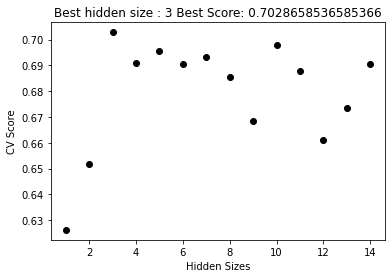

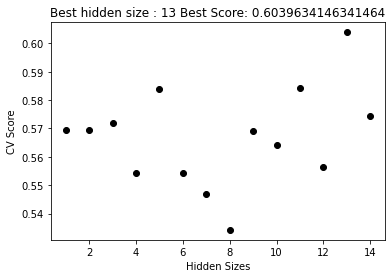

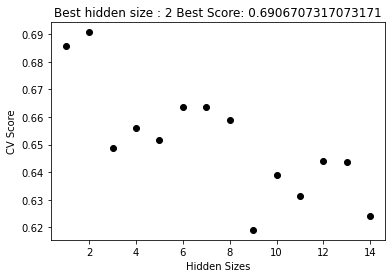

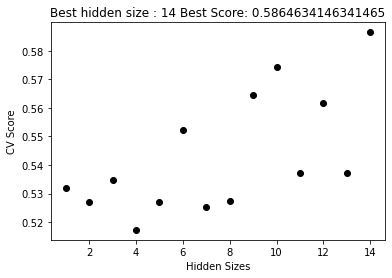

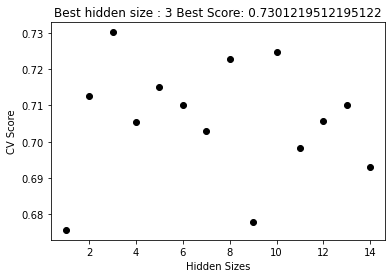

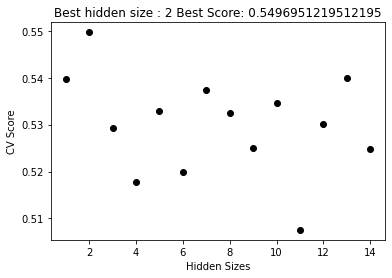

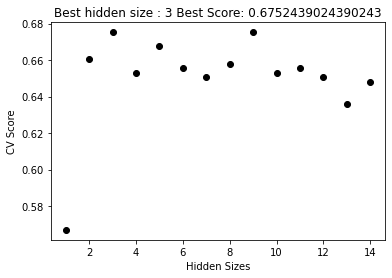

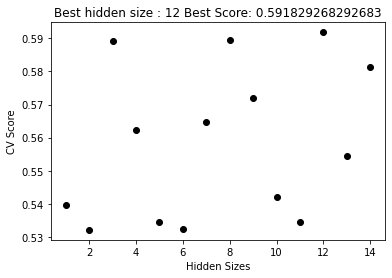

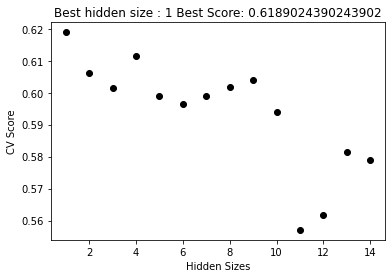

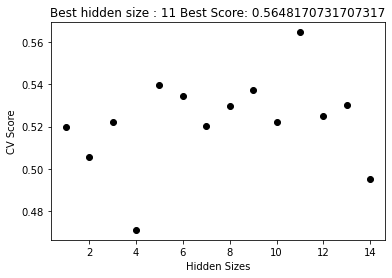

In [67]:
array_SNE = []
for i in range(1,11):
    array_SNE.append(month_test_TSNE(i))
print(array_SNE)

In [55]:
def month_test_SVD(month):
    temp1 = np.array([])
    temp2 = np.array([])
    temp_matrix = np.array([])

    temp1 = ext_data(temp1, month) 
    temp1 = temp1.reshape(404, 23)
    X_train = temp1[:,0:22]
    temp2 = ext_data(temp2, month+1) 
    temp2 = temp2.reshape(404, 23)
    X_test = temp2[:,0:22]
    temp_matrix = ext_data(temp_matrix, month+2)
    temp_matrix = temp_matrix.reshape(404, 23)

    ## target

    y_train = temp2[:,22]   
    y_test = temp_matrix[:,22] 
    
    avg = [14.60943332,5.531467255,1.055434182,-7.242647341,5.394251458,0.255385444,
           -0.932637353,0.393200319,1.893286984,-1.494307583,6.997469095]

    y_train = result(y_train, avg[month-1])   
    y_test = result(y_test, avg[month])
    
    X_std_test = Standardization(X_test)
    X_std_train = Standardization(X_train)
    
    X_new_train, X_new_test, y_train, y_test = new_SVD(X_std_train, X_std_test, y_train, y_test)
    return predict(X_new_train, X_new_test, y_train, y_test)
    

[0.5247524752475248, 0.4504950495049505, 0.4628712871287129, 0.4975247524752475, 0.5346534653465347, 0.5668316831683168, 0.47029702970297027, 0.4603960396039604, 0.4777227722772277, 0.4777227722772277]


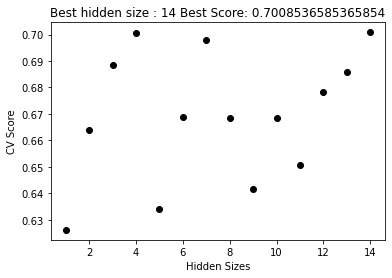

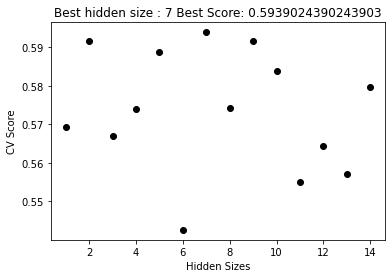

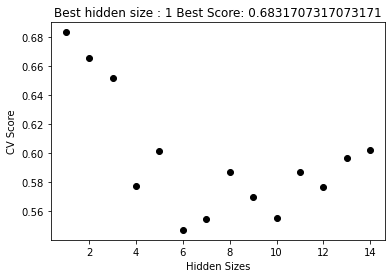

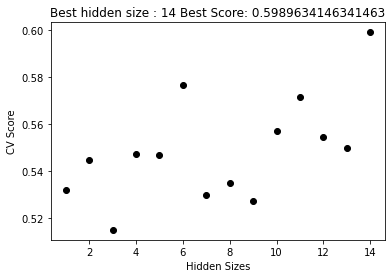

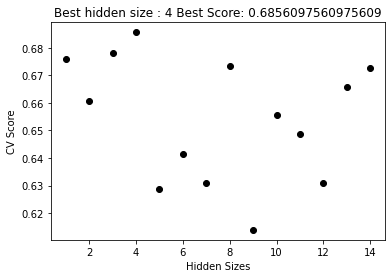

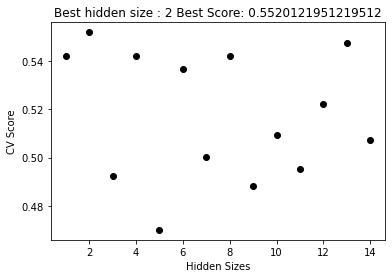

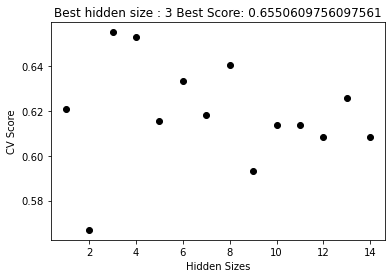

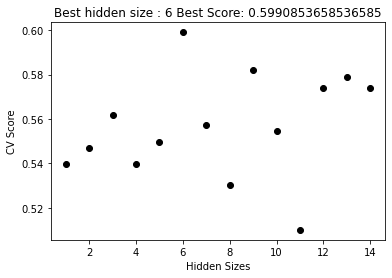

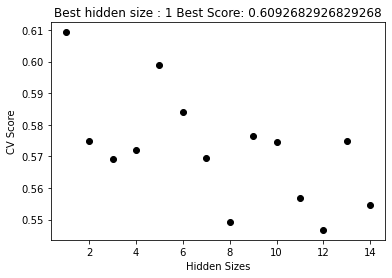

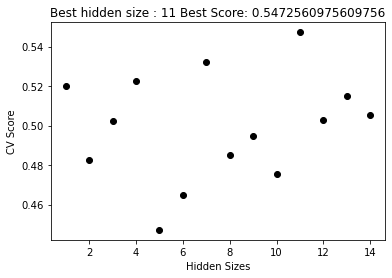

In [56]:
array_SVD = []
for i in range(1,11):
    array_SVD.append(month_test_SVD(i))
print(array_SVD)

In [58]:
import matplotlib.pyplot as plt

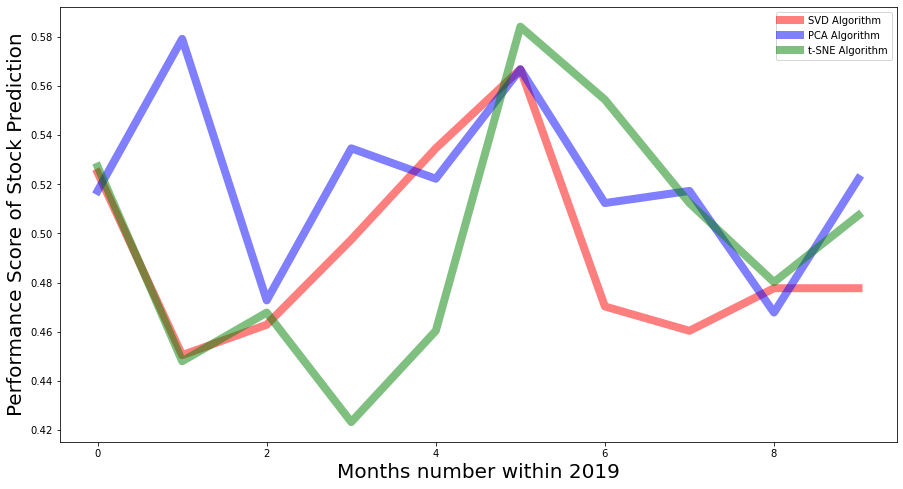

In [108]:
timelis = list(range(10))
plt. figure(figsize=(15,8))
plt.plot(timelis,array_SVD,color = "red",alpha = 0.5,linewidth = 8,label = "SVD Algorithm")
plt.plot(timelis,array_PCA,color = "blue",alpha = 0.5,linewidth = 8,label = "PCA Algorithm")
plt.plot(timelis,array_SNE, color = "green",alpha = 0.5,linewidth = 8, label = "t-SNE Algorithm")
plt.xlabel("Months number within 2019", fontsize = 20)
plt.ylabel("Performance Score of Stock Prediction", fontsize = 20)
plt.legend(loc="upper right")
plt.show()